In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def gen_random_obserr(mean, var, size, obs_intv, random_state=None):
    """
    Generate random gaussian observation error.
    
    Parameters:
    ----------
    mean, var: scaler.
        Mean and variance for gaussian distribution.
    size: int.
        The size of output array.
    obs_intv: int.
        The observation interval length in the output array.
    random_state: int.
        Random state. Default is None and it will use np.random.randint.
        
    Return:
    ------
    obs_err: 1-d array.
        The array which observation error occurs every `obs_intv` and others are 0.
        
    EX:
    >>> gen_random_obserr(0, 1, 12, 4)
    array([-0.34889445,  0,  0,  0,  0.98370343,  0,  0,  0,
           0.58092283,  0,  0,  0])
    """
    if random_state is None:
        random_state = np.random.randint(0, 50)
    
    length = np.ceil(size/obs_intv) * obs_intv
    obs_err = np.zeros(int(length)).reshape((-1,obs_intv))
    
    rng = np.random.RandomState(random_state)
    obs_err[:,0] = rng.normal(mean, np.sqrt(var), size=obs_err.shape[0])
    obs_err = obs_err.ravel()[:size]
    return obs_err


def lorenz63_fdm(x0, ts, sigma=None, r=None, b=None):
    """Solve lorenz63 with finit difference method"""  
    if sigma is None:
        sigma = 10
    if r is None:
        r = 28
    if b is None:
        b = 8/3
    
    size = ts.size
    dt = ts[1] - ts[0]
    
    x = np.zeros((size,))
    y = np.zeros((size,))
    z = np.zeros((size,))
    x[0] = x0[0]
    y[0] = x0[1]
    z[0] = x0[2]
    
    for i in range(1, size):
        x[i] = x[i-1] + sigma * (y[i-1] - x[i-1]) * dt
        y[i] = y[i-1] + (r*x[i-1] - y[i-1] - x[i-1]*z[i-1]) * dt
        z[i] = z[i-1] + (x[i-1]*y[i-1] - b*z[i-1]) * dt
    
    return np.vstack((x, y, z))


def M(xi, yi, zi, dt, sigma=None, r=None, b=None):
    """tangent linear model for lorenz63_fdm"""
    if sigma is None:
        sigma = 10
    if r is None:
        r = 28
    if b is None:
        b = 8/3
    
    M = np.array([
        [1-sigma*dt, sigma*dt, 0],
        [r*dt-zi*dt, 1-dt, -xi*dt],
        [yi*dt, xi*dt, 1-b*dt]
    ])
    return M


def stability_index_lorenz63(x, y, z, sigma=None, r=None, b=None):
    if sigma is None:
        sigma = 10
    if r is None:
        r = 28
    if b is None:
        b = 8/3
        
    M = np.array([
        [-sigma, sigma, 0],
        [r-z, -1, -x],
        [y, x, -b]
    ])
    
    eigv, P = np.linalg.eig(M)
    r = eigv.real
    if np.all(r<0):
        # stable case
        return r.sum()
    else:
        # unstable case
        r[r<0] = 0
        return r.sum()

In [6]:
X_ini = np.array([[8, 0, 30]]).T
dt = 0.01
time = 0.08
ts = np.arange(0, time, dt)

X_nature = lorenz63_fdm(X_ini.ravel(), ts)
X_nature.shape

(3, 8)

In [7]:
X_perturb = np.array([[4, 5, 10]]).T
X_forecast = lorenz63_fdm(X_perturb.ravel(), ts)

In [ ]:
obs = X_nature + np.random.randn(3, 8)

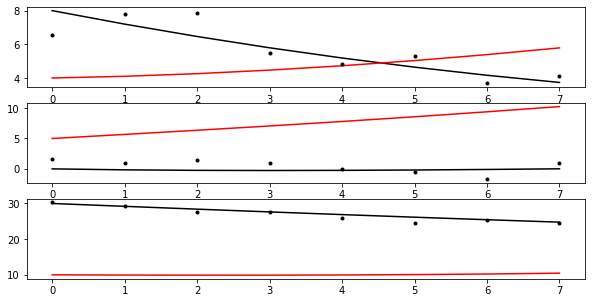

In [14]:
fig, axs = plt.subplots(nrows=3, figsize=(10, 5))
for i in range(3):
    axs[i].plot(X_nature[i,:], 'k')
    axs[i].plot(X_forecast[i,:], 'r')
    axs[i].plot(obs[i,:], 'k.')

In [129]:
def _4dvar_costfunction(x, xb, xtrac, yo, Pb, R, H_func=None):
    """
    x, xb: (ndim, 1)
    x_trac: (ndim, window)
    Pb: (ndim, ndim)
    yo: (N, window)
    R: (window, N, N)
    model, H_func: (window,)
    """
    assim_window_len = yo.shape[1]
    
    if H_func is None:
        H_func = [lambda arr: arr for _ in range(assim_window_len)]
        
    part1 = (xb-x).T @ np.linalg.inv(Pb) @ (xb-x)
    part2 = np.zeros_like(part1)
    for j in range(assim_window_len):
        yj = yo[:,[j]]
        Rj = R[j,:,:]
        H_j = H_func[j]
        xtracj = xtrac[:,[j]]
        part2 += (yj-H_j(xtracj)).T @ np.linalg.inv(Rj) @ (yj-H_j(xtracj))
    return 0.5 * (part1 + part2)

def _gradient_4dvar_costfunction(x, xb, xtrac, yo, Pb, R, M, H_func=None, H=None):
    """
    x, xb: (ndim, 1)
    xtrac: (ndim, window)
    Pb: (ndim, ndim)
    yo: (N, window)
    R: (window, N, N)
    H_func: (window,)
    M: (window, ndim, ndim)
    H: (window, N, ndim)
    """
    No, assim_window_len = yo.shape
    
    if H_func is None:
        H_func = [lambda arr: arr for _ in range(assim_window_len)]
        H = np.concatenate([np.eye(No)[np.newaxis] for i in range(assim_window_len)])
        
    part1 = np.linalg.inv(Pb) @ (x-xb)
    part2 = np.zeros_like(part1)
    for j in range(assim_window_len):
        yj = yo[:,[j]]
        Mj = M[j,:,:]
        Hj = H[j,:,:]
        Rj = R[j,:,:]
        H_fj = H_func[j]
        xtracj = xtrac[:,[j]]
        part2 += Mj.T @ Hj.T @ np.linalg.inv(Rj) @ (yj - H_fj(xtracj))
    return part1 - part2

In [114]:
xb = X_perturb
xb

array([[ 4],
       [ 5],
       [10]])

In [142]:
ts = np.arange(0, time, dt)
xb_forecast = lorenz63_fdm(xb.ravel(), ts)

Ms = []
m = np.eye(3)
for i in range(obs.shape[1]):
    m = M(xb_forecast[0,i], xb_forecast[1,i], xb_forecast[2,i], dt) @ m
    Ms.append(m)
Ms = np.stack(Ms)

In [143]:
Pb = np.array([
    [ 95.92487549, 108.82721654,  13.52170192],
    [108.82721654, 135.97355097,  18.39642468],
    [ 13.52170192,  18.39642468,  64.98710037]
])
Pb *= 0.02
R = np.eye(3) * 1
R = np.concatenate([1*np.eye(3)[np.newaxis,:,:] for i in range(8)])

_4dvar_costfunction(np.array([[8, 0, 30]]).T, xb, xb_forecast, obs, Pb, R)
_gradient_4dvar_costfunction(np.array([[8, 0, 30]]).T, xb, xb_forecast, obs, Pb, R, Ms)

array([[  44.1465144 ],
       [ -12.2222938 ],
       [-112.79376382]])

In [175]:
x = xb.copy()
for _ in range(1000):
    ts = np.arange(0, time, dt)
    xb_forecast = lorenz63_fdm(x.ravel(), ts)

    Ms = []
    m = np.eye(3)
    for i in range(obs.shape[1]):
        m = M(xb_forecast[0,i], xb_forecast[1,i], xb_forecast[2,i], dt) @ m
        Ms.append(m)
    Ms = np.stack(Ms)

    r = 0.01
    gradient = _gradient_4dvar_costfunction(x, xb, xb_forecast, obs, Pb, R, Ms)
    x_new = x - r * gradient

    #if np.abs((x_new-x)/x) <= 0.0001:
    print(np.linalg.norm(gradient))
    if np.linalg.norm(gradient) <= 0.001:
        break
    else:
        x = x_new

print(_, x_new)

133.74904873981842
123.20204808678375
113.54650668234359
104.69796141560275
96.58119457275241
89.129085723701
82.28161541418196
75.98500088838024
70.1909464311408
64.855993019757
59.940953862306806
55.41042409599878
51.23235443880193
47.377679941713126
43.819996188134446
40.535276342361094
37.50162337306744
34.69905258215776
32.10930026658835
29.715654942557116
27.50280807897395
25.456721730765185
23.564510841852645
21.814338311190298
20.19532119073329
18.69744661846233
17.311496288570652
16.028978429846465
14.84206640665862
13.743543178663135
12.72675095871239
11.785545496314619
10.914254488762014
10.107639685775577
9.360862307924558
8.669451445632225
8.029275145502025
7.436513925021093
6.887636486290125
6.379377425014596
5.908716753185573
5.472861073185654
5.069226257913621
4.695421506282183
4.349234656416702
4.028618650319626
3.73167905388128
3.4566625450932746
3.201946291310708
2.966028143539961
2.747517582113185
2.545127353841753
2.357665745896846
2.1840294463175804
2.023196945251

In [163]:
def f(x):
    return 5*(x-2)**2

def df(x):
    return 10*(x-2)
    
def gradient_descent(x0, func, dfunc, r=0.01, maxiter=100000):
    x = x0
    for _ in range(maxiter):
        x_new = x - r * df(x)
        if np.abs((x_new-x)/x) <= 0.00001:
            return x_new, True
        else:
            x = x_new
    return x_new, False

gradient_descent(100, 0.01)

2.0001681830658393

In [27]:
def _4dvar_costfunction(x, xb, yo, Pb, R, model, H_func=None):
    """
    x, xb: (ndim, 1)
    Pb: (ndim, ndim)
    yo: (N, window)
    R: (window, N, N)
    model, H_func: (window,)
    """
    assim_window_len = yo.shape[1]
    
    if H_func is None:
        H_func = [lambda arr: arr for _ in range(assim_window_len)]
        
    part1 =(xb-x).T @ np.linalg.inv(Pb) @ (xb-x)
    part2 = np.zeros_like(part1)
    for j in range(assim_window_len):
        yj = yo[:,[j]]
        Rj = R[j,:,:]
        H_j = H_func[j]
        m_j = model[j]
        part2 += (yj-H_j(m_j(x))).T @ np.linalg.inv(Rj) @ (yj-H_j(m_j(x)))
    return 0.5 * (part1 + part2)

def _gradient_4dvar_costfunction(x, xb, yo, Pb, R, M, H_func=None, H=None):
    """
    x, xb: (ndim, 1)
    Pb: (ndim, ndim)
    yo: (N, window)
    R: (window, N, N)
    model, H_func: (window,)
    M: (window, ndim, ndim)
    H: (window, N, ndim)
    """
    No, assim_window_len = yo.shape
    
    if H_func is None:
        H_func = [lambda arr: arr for _ in range(assim_window_len)]
        H = np.concatenate([np.eye(No)[np.newaxis] for i in range(assim_window_len)])
        
    part1 = np.linalg.inv(Pb) @ (x-xb)
    part2 = np.zeros_like(part1)
    for j in range(assim_window_len):
        yj = yo[:,[j]]
        Mj = M[j,:,:]
        Hj = H[j,:,:]
        Rj = R[j,:,:]
        H_fj = H_func[j]
        m_j = model[j]
        part2 += Mj.T @ Hj.T @ np.linalg.inv(Rj) @ (yj - H_fj(m_j(x)))
    return part1 - part2

In [33]:
xb = X_perturb
xb

array([[ 4],
       [ 5],
       [10]])

In [88]:
ts = np.arange(0, time, dt)
xb_forecast = lorenz63_fdm(xb.ravel(), ts)

model = [lambda x: x]
model += [lambda x: lorenz63_fdm(x.ravel(), np.arange(0, t+dt, dt))[:,[-1]] for t in ts[1:]]

model = []
for i in range(ts.size):
    if i == 0:
        model.append(lambda x: x)
    else:
        t = np.arange(0, ts[i]+dt, dt)
        model.append(lambda x: lorenz63_fdm(x.ravel(), t)[:,[-1]])

model[4](xb)

array([[ 5.78764962],
       [10.25406457],
       [10.45802341]])

In [63]:
[np.arange(0, t+dt, dt) for t in ts[1:]]

[array([0.  , 0.01]),
 array([0.  , 0.01, 0.02]),
 array([0.  , 0.01, 0.02, 0.03]),
 array([0.  , 0.01, 0.02, 0.03, 0.04]),
 array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05]),
 array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06]),
 array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07])]

In [77]:
lorenz63_fdm(xb.ravel(), np.arange(0, 0.04+dt, dt))

array([[ 4.        ,  4.1       ,  4.257     ,  4.46670333,  4.72613011],
       [ 5.        ,  5.67      ,  6.35403333,  7.06097107,  7.79850497],
       [10.        ,  9.93333333,  9.90091444,  9.90738126,  9.95857705]])

In [100]:
def model(x, time, dt):
    ts = np.arange(0, time+dt, dt)
    return lorenz63_fdm(x, ts)[:,[-1]]

models = [lambda x: model(x, t, dt) for t in ts]
models[0](xb)

array([[ 5.78764962],
       [10.25406457],
       [10.45802341]])

In [108]:
def f(a, b):
    return a+b

ff = [lambda a: f(a, i) for i in range(5)]
ff[0](1)

5